## Datasets

In [1]:
import pandas as pd

import urllib.request
import zipfile

In [2]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
    'kaggle-survey-2018.zip'
fname = '../data/kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [3]:
def extract_zip(src, dst, member_name):
    """Extract a member file from a zip file and read it into a pandas 
    DataFrame.
    
    Parameters:
        src (str): URL of the zip file to be downloaded and extracted.
        dst (str): Local file path where the zip file will be written.
        member_name (str): Name of the member file inside the zip file 
            to be read into a DataFrame.
    
    Returns:
        pandas.DataFrame: DataFrame containing the contents of the 
            member file.
    """    
    url = src
    fname = dst
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(dst, mode='wb') as fout:
        fout.write(data)
    with zipfile.ZipFile(dst) as z:
        kag = pd.read_csv(z.open(member_name))
        kag_questions = kag.iloc[0]
        raw = kag.iloc[1:]
        return raw

In [4]:
raw = extract_zip(url, fname, member_name)

/tmp/ipykernel_10067/1222519436.py:22: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,42,44,54,56,64,81,83,85,87,105,107,109,121,123,125,148,150,157,172,174,192,194,210,218,219,221,223,246,247,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,302,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  kag = pd.read_csv(z.open(member_name))


In [5]:
type(raw)

pandas.core.frame.DataFrame

## Cleanup Pipeline

In [6]:
import pandas as pd

from feature_engine import encoding, imputation
from sklearn import base, pipeline

In [7]:
def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the Kaggle survey data and return a new DataFrame.

    This function takes a Pandas DataFrame containing Kaggle 
    survey data as input and returns a new DataFrame. The 
    modifications include extracting and transforming certain 
    columns, renaming columns, and selecting a subset of columns.

    Parameters
    ----------
    df_ : pd.DataFrame
        The input DataFrame containing Kaggle survey data.

    Returns
    -------
    pd.DataFrame
        The new DataFrame with the modified and selected columns.
    """    
    return (df_
            .assign(age=df_.Q2.str.slice(0,2).astype(int),
                    education=df_.Q4.replace({'Master’s degree': 18,
                         'Bachelor’s degree': 16,
                         'Doctoral degree': 20,
'Some college/university study without earning a bachelor’s degree': 13,
                         'Professional degree': 19,
                         'I prefer not to answer': None,
                         'No formal education past high school': 12}),
                    major=(df_.Q5
                              .pipe(topn, n=3)
                              .replace({
                        'Computer science (software engineering, etc.)': 'cs',
                        'Engineering (non-computer focused)': 'eng',
                        'Mathematics or statistics': 'stat'})
                         ),
                    years_exp=(df_.Q8.str.replace('+','', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .astype(float)),
                    compensation=(df_.Q9.str.replace('+','', regex=False)
                           .str.replace(',','', regex=False)
                           .str.replace('500000', '500', regex=False)
  .str.replace('I do not wish to disclose my approximate yearly compensation',
             '0', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .fillna(0)
                           .astype(int)
                           .mul(1_000)
                                    ),
                    python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
                    r=df_.Q16_Part_2.fillna(0).replace('R', 1),
                    sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
               )#assign
        .rename(columns=lambda col:col.replace(' ', '_'))
        .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,'
                'python,r,sql'.split(',')]   
       )

        
def topn(ser, n=5, default='other'):
    """
    Replace all values in a Pandas Series that are not among 
    the top `n` most frequent values with a default value.

    This function takes a Pandas Series and returns a new 
    Series with the values replaced as described above. The 
    top `n` most frequent values are determined using the 
    `value_counts` method of the input Series.

    Parameters
    ----------
    ser : pd.Series
        The input Series.
    n : int, optional
        The number of most frequent values to keep. The 
        default value is 5.
    default : str, optional
        The default value to use for values that are not among 
        the top `n` most frequent values. The default value is 
        'other'.

    Returns
    -------
    pd.Series
        The modified Series with the values replaced.
    """    
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

In [8]:
class TweakKagTransformer(base.BaseEstimator,
    base.TransformerMixin):
    """
    A transformer for tweaking Kaggle survey data.

    This transformer takes a Pandas DataFrame containing 
    Kaggle survey data as input and returns a new version of 
    the DataFrame. The modifications include extracting and 
    transforming certain columns, renaming columns, and 
    selecting a subset of columns.

    Parameters
    ----------
    ycol : str, optional
        The name of the column to be used as the target variable. 
        If not specified, the target variable will not be set.

    Attributes
    ----------
    ycol : str
        The name of the column to be used as the target variable.
    """
    
    def __init__(self, ycol=None):
        self.ycol = ycol
        
    def transform(self, X):
        return tweak_kag(X)
    
    def fit(self, X, y=None):
        return self


In [9]:
def get_rawX_y(df, y_col):
    raw = (df
            .query('Q3.isin(["United States of America", "China", "India"]) '
               'and Q6.isin(["Data Scientist", "Software Engineer"])')
          )
    return raw.drop(columns=[y_col]), raw[y_col]

In [10]:
## Create a pipeline
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
     ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True, 
           variables=['Q1', 'Q3', 'major'])),
     ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
          variables=['education', 'years_exp']))]
)

In [11]:
from sklearn import model_selection

In [12]:
kag_X, kag_y = get_rawX_y(raw, 'Q6')

kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
    model_selection.train_test_split(
        kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)
X_test = kag_pl.transform(kag_X_test)

/tmp/ipykernel_10067/1754085967.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education=df_.Q4.replace({'Master’s degree': 18,
/tmp/ipykernel_10067/1754085967.py:51: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
/tmp/ipykernel_10067/1754085967.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `p

In [13]:
print(X_train)

       age  education  years_exp  compensation  python  r  sql  Q1_Male  \
587     25       18.0        4.0             0       1  0    1        1   
3065    22       16.0        1.0         10000       1  0    0        1   
8435    22       18.0        1.0             0       1  0    0        1   
3110    40       20.0        3.0        125000       1  0    1        0   
16372   45       12.0        5.0        100000       1  0    1        1   
...    ...        ...        ...           ...     ... ..  ...      ...   
16608   25       16.0        2.0         10000       0  0    1        1   
7325    18       16.0        1.0         30000       1  0    1        1   
21810   18       16.0        2.0             0       0  0    0        1   
4917    25       18.0        1.0        100000       1  0    1        1   
639     25       18.0        1.0         10000       1  0    0        0   

       Q1_Female  Q1_Prefer not to say  Q1_Prefer to self-describe  \
587            0             

In [14]:
kag_y_train

587      Software Engineer
3065        Data Scientist
8435        Data Scientist
3110        Data Scientist
16372    Software Engineer
               ...        
16608    Software Engineer
7325     Software Engineer
21810       Data Scientist
4917        Data Scientist
639         Data Scientist
Name: Q6, Length: 2110, dtype: object

## EDA

In [15]:
pd.__version__

'2.2.2'

In [16]:
(X_train
 .assign(data_scientist = kag_y_train == 'Data Scientist')
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu', vmax=1, vmin=-1)
 .set_sticky(axis='index')
)

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat,data_scientist
age,1.000000,0.345717,0.644863,0.451349,0.046651,0.127667,0.134325,0.014277,-0.033693,0.051232,0.041474,0.371123,-0.363626,-0.023384,-0.223529,0.201910,0.006262,0.073864,0.075440
education,0.345717,1.000000,0.098849,0.241393,0.060259,0.151244,0.066620,-0.079534,0.064777,0.060984,0.002701,0.272790,-0.273408,-0.006441,-0.216724,0.164771,-0.001043,0.121294,0.266717
years_exp,0.644863,0.098849,1.000000,0.255164,-0.055408,0.012090,0.050181,0.083624,-0.097564,0.034470,0.016784,0.117912,-0.136666,0.029630,-0.046551,0.018267,0.004264,0.042917,-0.145461
compensation,0.451349,0.241393,0.255164,1.000000,0.165070,0.171485,0.201336,0.000967,0.002912,-0.035554,0.049881,0.616759,-0.556154,-0.123281,-0.225934,0.241580,-0.060256,0.109100,0.174434
python,0.046651,0.060259,-0.055408,0.165070,1.000000,0.183665,0.287957,0.039944,-0.039207,-0.006729,-0.000553,0.052339,-0.043101,-0.017642,-0.095136,0.093887,0.008640,0.013474,0.121741
r,0.127667,0.151244,0.012090,0.171485,0.183665,1.000000,0.276862,-0.066982,0.068157,0.004831,-0.004454,0.178682,-0.105625,-0.133029,-0.205538,0.139994,-0.022082,0.162942,0.329124
sql,0.134325,0.066620,0.050181,0.201336,0.287957,0.276862,1.000000,-0.026692,0.032639,-0.010814,-0.018499,0.166587,-0.107382,-0.108406,-0.130081,0.109862,-0.012964,0.073906,0.117941
Q1_Male,0.014277,-0.079534,0.083624,0.000967,0.039944,-0.066982,-0.026692,1.000000,-0.957007,-0.222963,-0.094664,-0.144665,0.116961,0.052566,0.062605,-0.071139,0.028492,-0.039544,-0.091126
Q1_Female,-0.033693,0.064777,-0.097564,0.002912,-0.039207,0.068157,0.032639,-0.957007,1.000000,-0.045225,-0.019201,0.131051,-0.105490,-0.048434,-0.049753,0.064054,-0.034760,0.036779,0.086614
Q1_Prefer not to say,0.051232,0.060984,0.034470,-0.035554,-0.006729,0.004831,-0.010814,-0.222963,-0.045225,1.000000,-0.004473,0.046366,-0.038587,-0.014918,-0.045908,0.010336,0.029149,0.021052,0.018540


In [17]:
import matplotlib.pyplot as plt

<Axes: xlabel='r'>

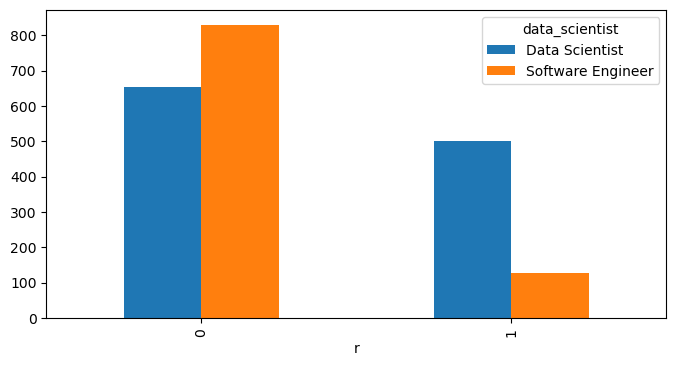

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
(X_train
 .assign(data_scientist = kag_y_train)
 .groupby('r')
 .data_scientist
 .value_counts()
 .unstack()
 .plot.bar(ax=ax)
)

<Axes: xlabel='major_cs'>

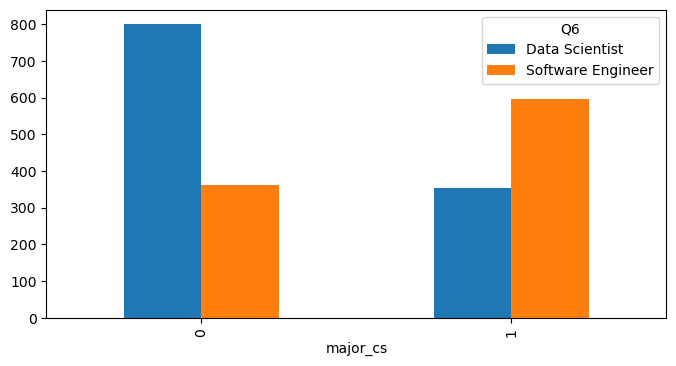

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
(pd.crosstab(index=X_train['major_cs'], 
             columns=kag_y)
    .plot.bar(ax=ax)
)

<Axes: xlabel='years_exp', ylabel='compensation'>

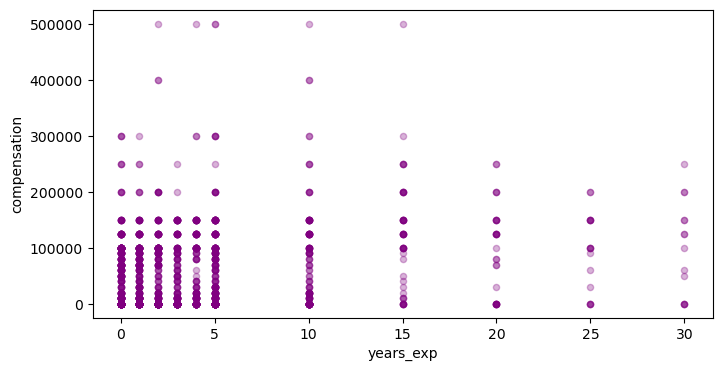

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
(X_train
 .plot.scatter(x='years_exp', y='compensation', alpha=.3, ax=ax, c='purple')
)

In [21]:
import seaborn.objects as so

In [41]:
fig = plt.figure(figsize=(8, 4))

<Figure size 800x400 with 0 Axes>

/home/lselvera/anaconda3/lib/python3.11/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):
/home/lselvera/anaconda3/lib/python3.11/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):
/home/lselvera/anaconda3/lib/python3.11/site-packages/seaborn/_core/plot.py:1525: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  df_subset = grouped_df.get_group(pd_key)
/home/lselvera/anaconda3/lib/python3.11/site-packages/seaborn/_core/plot.py:1525: FutureWarning: When grouping with a le

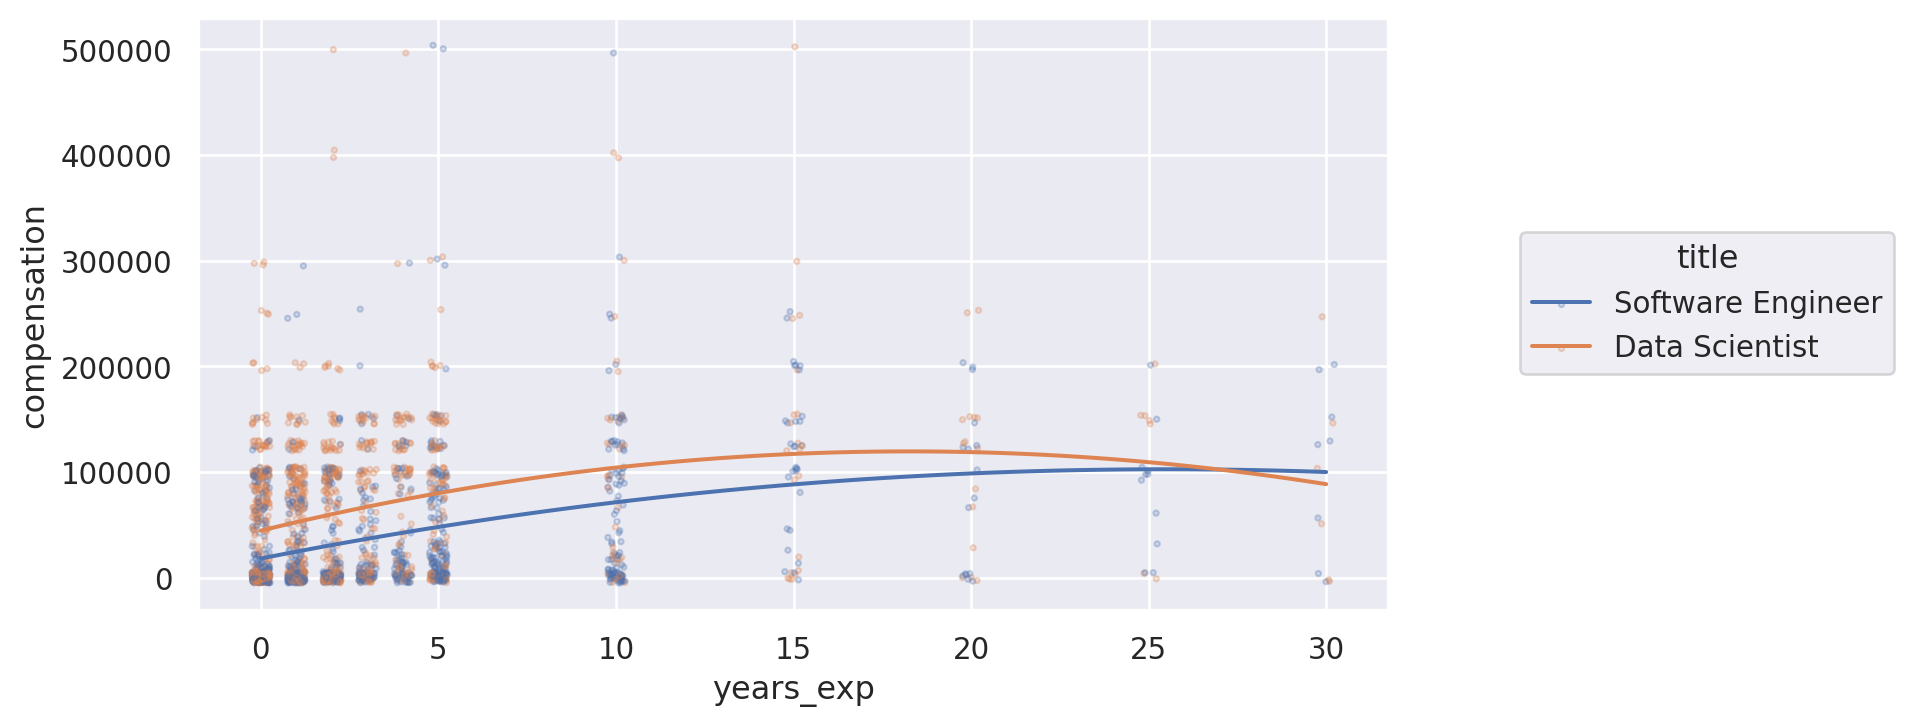

In [42]:
(so
 .Plot(X_train.assign(title=kag_y_train), x='years_exp', y='compensation', color='title')
 .add(so.Dots(alpha=.3, pointsize=2), so.Jitter(x=.5, y=10_000))
 .add(so.Line(), so.PolyFit())
 .on(fig)  # not required unless saving to image
 .plot()   # ditto
)

In [49]:
fig = plt.figure(figsize=(8, 4))

<Figure size 800x400 with 0 Axes>

/home/lselvera/anaconda3/lib/python3.11/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):
/home/lselvera/anaconda3/lib/python3.11/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):
/home/lselvera/anaconda3/lib/python3.11/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):
/home/lselvera/anaconda3/lib/python3.11/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

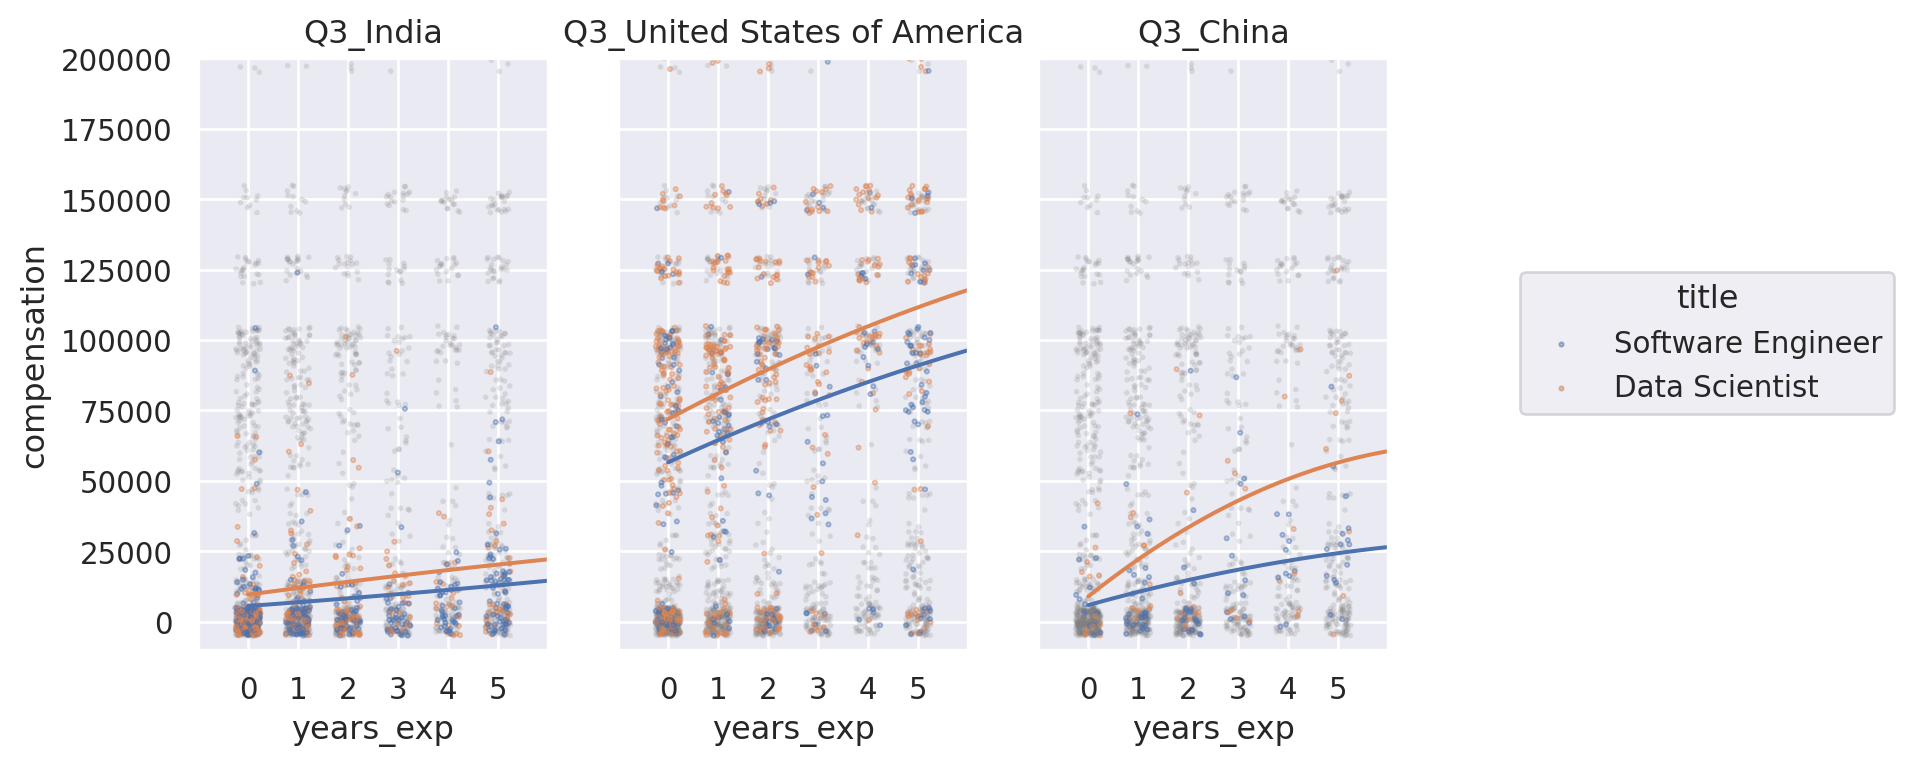

In [50]:
(so
 .Plot(X_train
       #.query('compensation < 200_000 and years_exp < 16')
       .assign(
         title=kag_y_train,
         country=(X_train
             .loc[:, 'Q3_United States of America': 'Q3_China']
             .idxmax(axis='columns')
            )
       ), x='years_exp', y='compensation', color='title')
 .facet('country')
 .add(so.Dots(alpha=.01, pointsize=2, color='grey' ), so.Jitter(x=.5, y=10_000), col=None)
 .add(so.Dots(alpha=.5, pointsize=1.5), so.Jitter(x=.5, y=10_000))
 .add(so.Line(pointsize=1), so.PolyFit(order=2))
 .scale(x=so.Continuous().tick(at=[0,1,2,3,4,5]))
 .limit(y=(-10_000, 200_000), x=(-1, 6))  # zoom in with this not .query (above)
 .on(fig)  # not required unless saving to image
 .plot()   # ditto
)